In [2]:
import pandas as pd

In [6]:
!wget -P data/full_dataset/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_1.csv
!wget -P data/full_dataset/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_2.csv
!wget -P data/full_dataset/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_3.csv

--2025-03-13 15:01:36--  https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_1.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.179.207, 108.177.121.207, 209.85.145.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.179.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14174600 (14M) [application/octet-stream]
Saving to: ‘data/full_dataset/goemotions_1.csv’

goemotions_1.csv    100%[===================>]  13.52M  58.7MB/s    in 0.2s    

2025-03-13 15:01:36 (58.7 MB/s) - ‘data/full_dataset/goemotions_1.csv’ saved [14174600/14174600]

--2025-03-13 15:01:36--  https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_2.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.179.207, 108.177.121.207, 209.85.145.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.179.207|:443... connected.
HTTP request sent, awaiting res

In [64]:
goemotions_1 = pd.read_csv('data/full_dataset/goemotions_1.csv')
goemotions_2 = pd.read_csv('data/full_dataset/goemotions_2.csv')
goemotions_3 = pd.read_csv('data/full_dataset/goemotions_3.csv')

combined_df = pd.concat([goemotions_1, goemotions_2, goemotions_3], ignore_index=True)
emotion_columns = combined_df.columns[9:]


combined_df['created_utc'] = pd.to_datetime(combined_df['created_utc'], unit='s', errors='coerce')
combined_df.to_csv('data/full_dataset/goemotions_combined.csv', index=False)
combined_df = combined_df.query("example_very_unclear != True")

In [65]:
def _calculate_rater_summary(combined_df):
        """
        Summarize the emotions annotated by each rater.

        Returns:
            pd.DataFrame: Summary of total emotions annotated by each rater.
        """
        rater_summary = combined_df.groupby('rater_id')[emotion_columns].sum()
        rater_summary['total_annotations'] = rater_summary.sum(axis=1)
        rater_summary['unique_emotions'] = (rater_summary[emotion_columns] > 0).sum(axis=1)
        rater_summary['total_statuses_tagged'] = combined_df.groupby('rater_id').size()
        return rater_summary

retr = _calculate_rater_summary(combined_df)
retr

,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,disappointment,...,pride,realization,relief,remorse,sadness,surprise,neutral,total_annotations,unique_emotions,total_statuses_tagged
rater_id,,,,,,,,,,,,,,,,,,,,,
0,0,3,3,3,0,2,0,0,1,1,...,0,3,1,1,3,0,15,60,18,48
1,58,89,120,62,70,31,10,16,22,51,...,36,10,18,33,69,94,437,2004,28,1500
2,488,127,313,324,172,122,186,272,191,154,...,119,92,74,96,315,212,1180,6617,28,5755
3,261,147,51,132,823,134,129,447,100,133,...,28,596,12,23,121,256,320,4831,28,3731
4,849,676,485,718,1318,189,633,567,88,196,...,32,142,18,41,248,231,2655,11713,28,10508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,35,42,21,182,33,40,78,52,20,50,...,6,36,13,18,26,27,165,1057,28,902
78,173,69,77,209,100,90,59,139,17,105,...,13,12,7,4,52,65,489,2132,28,1869
79,115,23,43,135,135,54,58,36,39,165,...,12,128,11,4,35,12,22,1555,28,833


In [66]:
rater_summary_filtered = retr[retr['unique_emotions'] == 28]

In [67]:
rater_summary_filtered['total_statuses_tagged'].sum()

174852

In [68]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def normalize_rater_emotions(rater_summary_filtered, emotion_columns):
    """
    Normalize the emotion columns for each rater so that the sum of emotions per rater equals 1.

    Args:
        rater_summary_filtered (pd.DataFrame): Filtered dataframe containing rater emotion statistics.
        emotion_columns (list): List of emotion-related columns.

    Returns:
        pd.DataFrame: Normalized dataframe where each row sums to 1.
    """
    rater_summary_normalized = rater_summary_filtered.copy()

    emotion_sums = rater_summary_normalized[emotion_columns].sum(axis=1)

    rater_summary_normalized[emotion_columns] = rater_summary_normalized[emotion_columns].div(emotion_sums, axis=0).fillna(0)

    return rater_summary_normalized

rater_summary_normalized = normalize_rater_emotions(rater_summary_filtered,emotion_columns)
rater_summary_normalized

,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,disappointment,...,pride,realization,relief,remorse,sadness,surprise,neutral,total_annotations,unique_emotions,total_statuses_tagged
rater_id,,,,,,,,,,,,,,,,,,,,,
1,0.028942,0.044411,0.059880,0.030938,0.034930,0.015469,0.004990,0.007984,0.010978,0.025449,...,0.017964,0.004990,0.008982,0.016467,0.034431,0.046906,0.218064,2004,28,1500
2,0.073749,0.019193,0.047302,0.048965,0.025994,0.018437,0.028109,0.041106,0.028865,0.023273,...,0.017984,0.013904,0.011183,0.014508,0.047605,0.032039,0.178329,6617,28,5755
3,0.054026,0.030428,0.010557,0.027324,0.170358,0.027738,0.026703,0.092527,0.020700,0.027531,...,0.005796,0.123370,0.002484,0.004761,0.025047,0.052991,0.066239,4831,28,3731
4,0.072484,0.057714,0.041407,0.061299,0.112525,0.016136,0.054043,0.048408,0.007513,0.016734,...,0.002732,0.012123,0.001537,0.003500,0.021173,0.019722,0.226671,11713,28,10508
5,0.107593,0.078514,0.035218,0.030695,0.025848,0.039095,0.028756,0.037480,0.012601,0.021002,...,0.001939,0.034895,0.007431,0.013893,0.026494,0.037480,0.212601,3095,28,2939
7,0.026775,0.043587,0.016189,0.034869,0.027397,0.008095,0.032379,0.091532,0.009340,0.065380,...,0.003736,0.105853,0.001868,0.003113,0.094022,0.032379,0.112702,1606,28,1424
8,0.067212,0.032243,0.040872,0.065849,0.051317,0.044505,0.036785,0.003633,0.022252,0.039055,...,0.005904,0.008629,0.008174,0.012262,0.012262,0.024069,0.311535,2202,28,2022
9,0.048000,0.018000,0.020667,0.076000,0.057333,0.044000,0.027333,0.096667,0.024667,0.040667,...,0.020000,0.032000,0.017333,0.013333,0.048000,0.043333,0.022000,1500,28,898
10,0.111193,0.032617,0.020015,0.024463,0.076353,0.020015,0.023721,0.008154,0.008154,0.027428,...,0.002965,0.083766,0.008895,0.014826,0.022980,0.023721,0.226093,1349,28,1117


In [69]:
rater_summary_normalized[emotion_columns]

,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,disappointment,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
rater_id,,,,,,,,,,,,,,,,,,,,,
1,0.028942,0.044411,0.059880,0.030938,0.034930,0.015469,0.004990,0.007984,0.010978,0.025449,...,0.103293,0.009980,0.017465,0.017964,0.004990,0.008982,0.016467,0.034431,0.046906,0.218064
2,0.073749,0.019193,0.047302,0.048965,0.025994,0.018437,0.028109,0.041106,0.028865,0.023273,...,0.051987,0.006045,0.027656,0.017984,0.013904,0.011183,0.014508,0.047605,0.032039,0.178329
3,0.054026,0.030428,0.010557,0.027324,0.170358,0.027738,0.026703,0.092527,0.020700,0.027531,...,0.018837,0.004761,0.019251,0.005796,0.123370,0.002484,0.004761,0.025047,0.052991,0.066239
4,0.072484,0.057714,0.041407,0.061299,0.112525,0.016136,0.054043,0.048408,0.007513,0.016734,...,0.008025,0.002220,0.024417,0.002732,0.012123,0.001537,0.003500,0.021173,0.019722,0.226671
5,0.107593,0.078514,0.035218,0.030695,0.025848,0.039095,0.028756,0.037480,0.012601,0.021002,...,0.021648,0.004523,0.014216,0.001939,0.034895,0.007431,0.013893,0.026494,0.037480,0.212601
7,0.026775,0.043587,0.016189,0.034869,0.027397,0.008095,0.032379,0.091532,0.009340,0.065380,...,0.016812,0.001868,0.096513,0.003736,0.105853,0.001868,0.003113,0.094022,0.032379,0.112702
8,0.067212,0.032243,0.040872,0.065849,0.051317,0.044505,0.036785,0.003633,0.022252,0.039055,...,0.029973,0.002725,0.016803,0.005904,0.008629,0.008174,0.012262,0.012262,0.024069,0.311535
9,0.048000,0.018000,0.020667,0.076000,0.057333,0.044000,0.027333,0.096667,0.024667,0.040667,...,0.011333,0.027333,0.012667,0.020000,0.032000,0.017333,0.013333,0.048000,0.043333,0.022000
10,0.111193,0.032617,0.020015,0.024463,0.076353,0.020015,0.023721,0.008154,0.008154,0.027428,...,0.043736,0.001483,0.031875,0.002965,0.083766,0.008895,0.014826,0.022980,0.023721,0.226093


In [70]:
import pandas as pd

def get_dominant_emotion(rater_summary_normalized, emotion_columns):
    """
    Identifies the dominant emotion for each rater.

    Args:
        rater_summary_normalized (pd.DataFrame): DataFrame containing normalized emotion scores per rater.
        emotion_columns (list): List of emotion-related columns.

    Returns:
        pd.DataFrame: A DataFrame with the dominant emotion for each rater.
    """
    rater_summary_with_dominant = rater_summary_normalized.copy()

    rater_summary_with_dominant['dominant_emotion'] = rater_summary_with_dominant[emotion_columns].idxmax(axis=1)

    return rater_summary_with_dominant[['dominant_emotion']]

rater_dominant_emotion = get_dominant_emotion(rater_summary_normalized, emotion_columns)

rater_dominant_emotion


,dominant_emotion
rater_id,
1,neutral
2,neutral
3,approval
4,neutral
5,neutral
7,neutral
8,neutral
9,curiosity
10,neutral


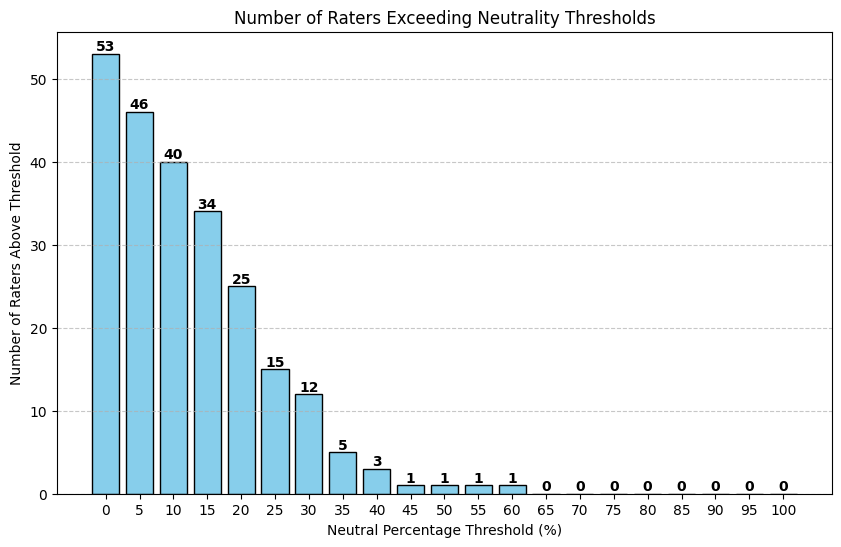

In [71]:
import matplotlib.pyplot as plt

def plot_rater_neutral_thresholds(rater_summary_normalized, step=5):
    """
    Plots the number of raters exceeding different neutrality percentage thresholds.

    Args:
        rater_summary_normalized (pd.DataFrame): DataFrame with normalized emotions.
        step (int): Step size for threshold increments (default: 5%).
    """
    neutral_percentages = rater_summary_normalized['neutral'] * 100

    thresholds = list(range(0, 101, step))
    raters_above_threshold = [sum(neutral_percentages >= t) for t in thresholds]

    plt.figure(figsize=(10, 6))
    bars = plt.bar(thresholds, raters_above_threshold, width=step*0.8, color='skyblue', edgecolor='black')

    for bar, count in zip(bars, raters_above_threshold):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), str(count),
                 ha='center', va='bottom', fontsize=10, fontweight='bold')

    plt.xlabel("Neutral Percentage Threshold (%)")
    plt.ylabel("Number of Raters Above Threshold")
    plt.title("Number of Raters Exceeding Neutrality Thresholds")
    plt.xticks(thresholds)
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    plt.show()

plot_rater_neutral_thresholds(rater_summary_normalized)



In [72]:
import pandas as pd

def categorize_raters_by_neutrality(df):
    """
    Categorizes raters based on their neutrality percentage.

    Args:
        df (pd.DataFrame): DataFrame containing normalized emotion data.

    Returns:
        pd.DataFrame: DataFrame with an added 'neutrality_category' column.
    """
    df = df.copy()
    df['neutrality_category'] = 'Balanced'

    df.loc[df['neutral'] * 100 > 40, 'neutrality_category'] = 'Highly Neutral'
    df.loc[df['neutral'] * 100 < 15, 'neutrality_category'] = 'Emotional'

    return df

rater_summary_categorized = categorize_raters_by_neutrality(rater_summary_normalized).reset_index()


print(rater_summary_categorized['neutrality_category'].value_counts())



neutrality_category
Balanced          31
Emotional         19
Highly Neutral     3
Name: count, dtype: int64


In [73]:
highly_neutral_raters = rater_summary_categorized[rater_summary_categorized['neutrality_category'] == 'Highly Neutral']
balanced_raters = rater_summary_categorized[rater_summary_categorized['neutrality_category'] == 'Balanced']
emotional_raters = rater_summary_categorized[rater_summary_categorized['neutrality_category'] == 'Emotional']

emotional_raters['total_statuses_tagged'].sum() , highly_neutral_raters['total_statuses_tagged'].sum(), balanced_raters['total_statuses_tagged'].sum()

(48446, 9712, 116694)

In [84]:
highly_neutral_raters = rater_summary_categorized[rater_summary_categorized['neutrality_category'] == 'Highly Neutral']
balanced_raters = rater_summary_categorized[rater_summary_categorized['neutrality_category'] == 'Balanced']
emotional_raters = rater_summary_categorized[rater_summary_categorized['neutrality_category'] == 'Emotional']

highly_neutral_ids = highly_neutral_raters['rater_id'].tolist()
balanced_ids = balanced_raters['rater_id'].tolist()
emotional_ids = emotional_raters['rater_id'].tolist()


highly_neutral_data = combined_df[combined_df['rater_id'].isin(highly_neutral_ids)]
balanced_data = combined_df[combined_df['rater_id'].isin(balanced_ids)]
emotional_data = combined_df[combined_df['rater_id'].isin(emotional_ids)]

In [85]:
emotional_data

,text,id,author,subreddit,link_id,parent_id,created_utc,rater_id,example_very_unclear,admiration,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
2,"You do right, if you don't care then fuck 'em!",ed2mah1,Labalool,confessions,t3_abru74,t1_ed2m7g7,2019-01-02 11:15:44,37,False,0,...,0,0,0,0,0,0,0,0,0,1
5,Right? Considering it’s such an important docu...,eespn2i,ImperialBoss,TrueReddit,t3_aizyuz,t1_eesoak0,2019-01-23 21:50:08,61,False,0,...,0,0,0,0,0,0,0,0,0,0
6,"He isn't as big, but he's still quite popular....",eczuekb,Rallings,cringe,t3_abeksv,t1_eczsmp8,2019-01-01 05:21:16,3,False,0,...,0,0,0,0,0,0,0,0,0,0
8,that's adorable asf,ef961hv,RedRails1917,traaaaaaannnnnnnnnns,t3_akz2ia,t3_akz2ia,2019-01-29 12:05:43,73,False,0,...,0,0,0,0,0,0,0,0,0,0
9,"""Sponge Blurb Pubs Quaw Haha GURR ha AAa!"" fin...",edl7cr3,Tiagulus,youtubehaiku,t3_acuvb0,t1_edc21ip,2019-01-08 21:38:34,54,False,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211199,Isn't there a sub for tomorrow exact post?,ef6xgh0,bobdole12122,ComedyCemetery,t3_akqc2q,t3_akqc2q,2019-01-28 18:28:37,48,False,0,...,0,0,0,0,0,0,0,0,0,0
211202,Yes!!!!!! She’s a hot mess!,eelj139,russian262,loveafterlockup,t3_ai0ccm,t1_eel39qp,2019-01-21 04:50:49,37,False,0,...,0,0,0,0,0,0,0,0,0,0
211203,Perhaps you are right and the stereotype that ...,ef8mcsc,byronwindstrom,aspergers,t3_akqz7a,t1_ef7ri54,2019-01-29 05:49:35,37,False,0,...,0,0,0,0,0,0,0,0,0,1
211216,Tell her youre sleeping with someone else. You...,ef4hcnj,dangthatsnasty,datingoverthirty,t3_ak555p,t1_ef2tvod,2019-01-27 21:13:12,7,False,0,...,0,0,0,0,0,0,0,0,0,0


In [87]:
highly_neutral_data.to_csv("data/highly_neutral_data.csv", index=False)
balanced_data.to_csv("data/balanced_data.csv", index=False)
emotional_data.to_csv("data/emotional_data.csv", index=False)

print("Files saved successfully:")
print("Highly Neutral Data: data/highly_neutral_data.csv")
print("Balanced Data: data/balanced_data.csv")
print("Emotional Data: data/emotional_data.csv")

Files saved successfully:
Highly Neutral Data: data/highly_neutral_data.csv
Balanced Data: data/balanced_data.csv
Emotional Data: data/emotional_data.csv
